In [1]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from latent_immunity_relative_fitness import RelativeFitnessDR, LatentRW, LatentSplineRW

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax
from jax import jit, lax
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

In [3]:
#raw_seq = pd.read_csv("../../evofr/test/testing_data/mlr-variant-counts.tsv", sep="\t")
#raw_seq = raw_seq[raw_seq.location == "City0"]
#data = ef.VariantFrequencies(raw_seq, pivot="C")

In [4]:
raw_seq = pd.read_csv("../../rt-from-frequency-dynamics/data/variants-us/variants-us_location-variant-sequence-counts.tsv", sep="\t")
raw_seq
#data = ef.VariantFrequencies(raw_seq)
data = ef.HierFrequencies(raw_seq, group="location")

In [5]:
from evofr.plotting import FrequencyPlot, GrowthAdvantagePlot, TimeVaryingPlot, PatchLegend

#freq_plot = FrequencyPlot(data=data).plot(posterior=False);
#PatchLegend(color_map=freq_plot.color_map).add_legend(ax=freq_plot.ax);

In [6]:
phi_model = LatentSplineRW(ef.Spline(order=4, k=4))
latent_dim = 3
model = RelativeFitnessDR(dim=latent_dim, phi_model=phi_model, hier=True)
inference_method = ef.InferNUTS(num_samples=500, num_warmup=500)
inference_method = ef.InferMAP(lr=4e-4, iters=50_000)

posterior = inference_method.fit(model, data=data)

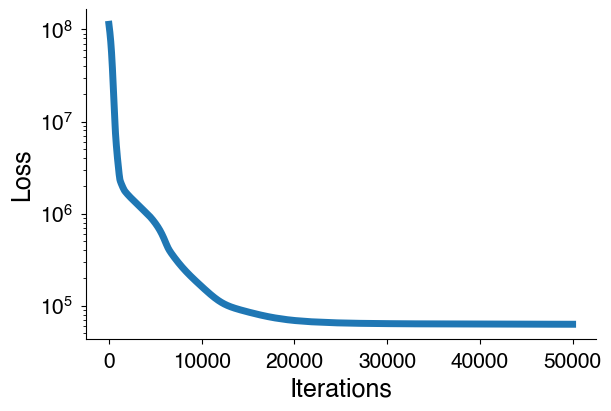

In [7]:
if "losses" in posterior.samples.keys():
    fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    ax.plot(posterior.samples["losses"])
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Iterations")

In [8]:
def get_groups(samples, sites, group):
    samples_group = dict()
    for site in sites:
        samples_group[site] = samples[site][..., group] 
    return samples_group

def get_posterior(posterior, sites, group):
    _samples = get_groups(posterior.samples, sites, group)
    _data = posterior.data.groups[group]
    return ef.PosteriorHandler(samples=_samples, data=_data)

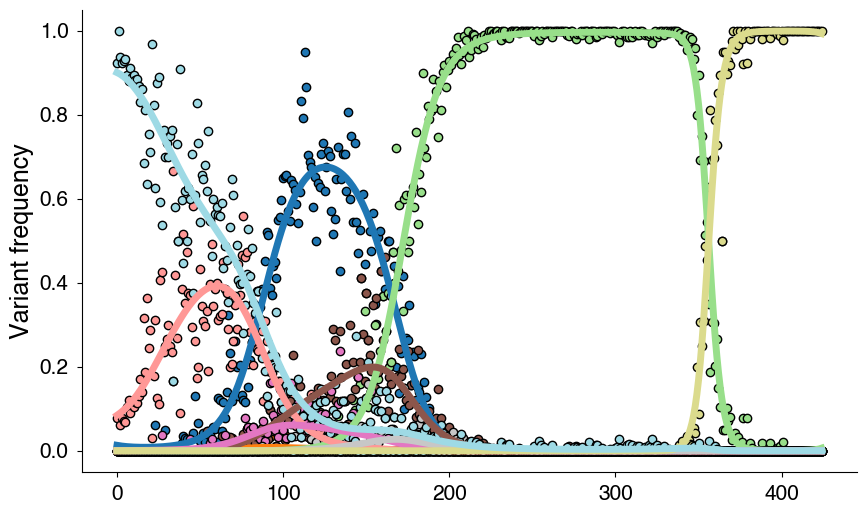

In [9]:
_posterior = get_posterior(posterior, ["freq", "delta", "phi", "phi_0"], 0)
freq_plot = FrequencyPlot(_posterior).plot();

Text(0, 0.5, 'Phi')

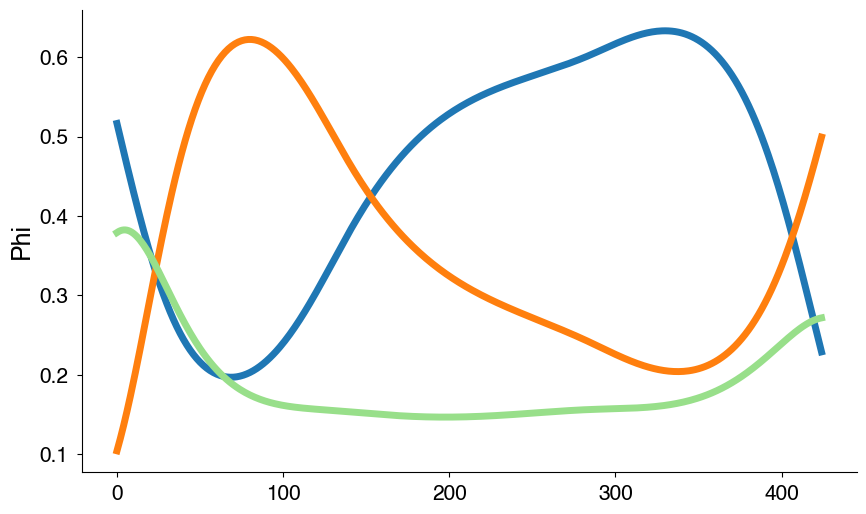

In [10]:
phi_plot = TimeVaryingPlot(posterior=_posterior, site="phi").plot()
phi_plot.ax.set_ylabel("Phi")

Text(0, 0.5, 'Relative Fitness')

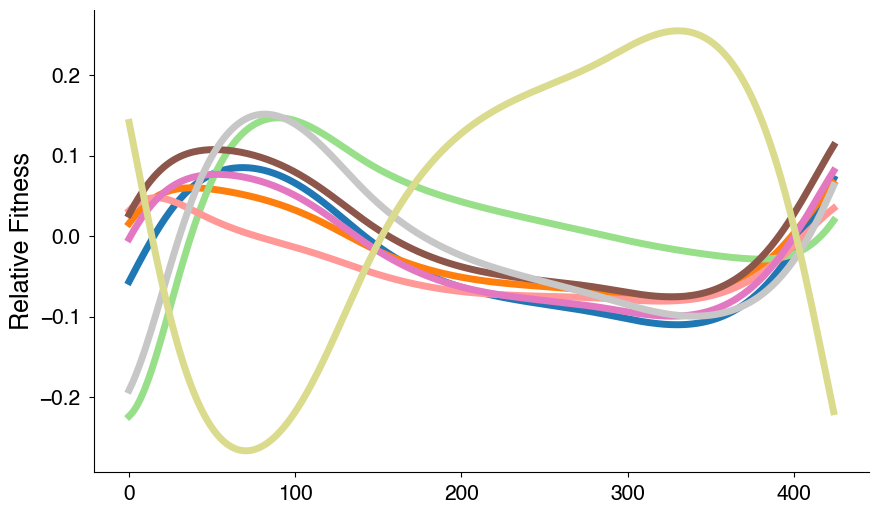

In [11]:
delta_plot = TimeVaryingPlot(posterior=_posterior, site="delta").plot()
delta_plot.ax.set_ylabel("Relative Fitness")

In [29]:
latent_dim = 3

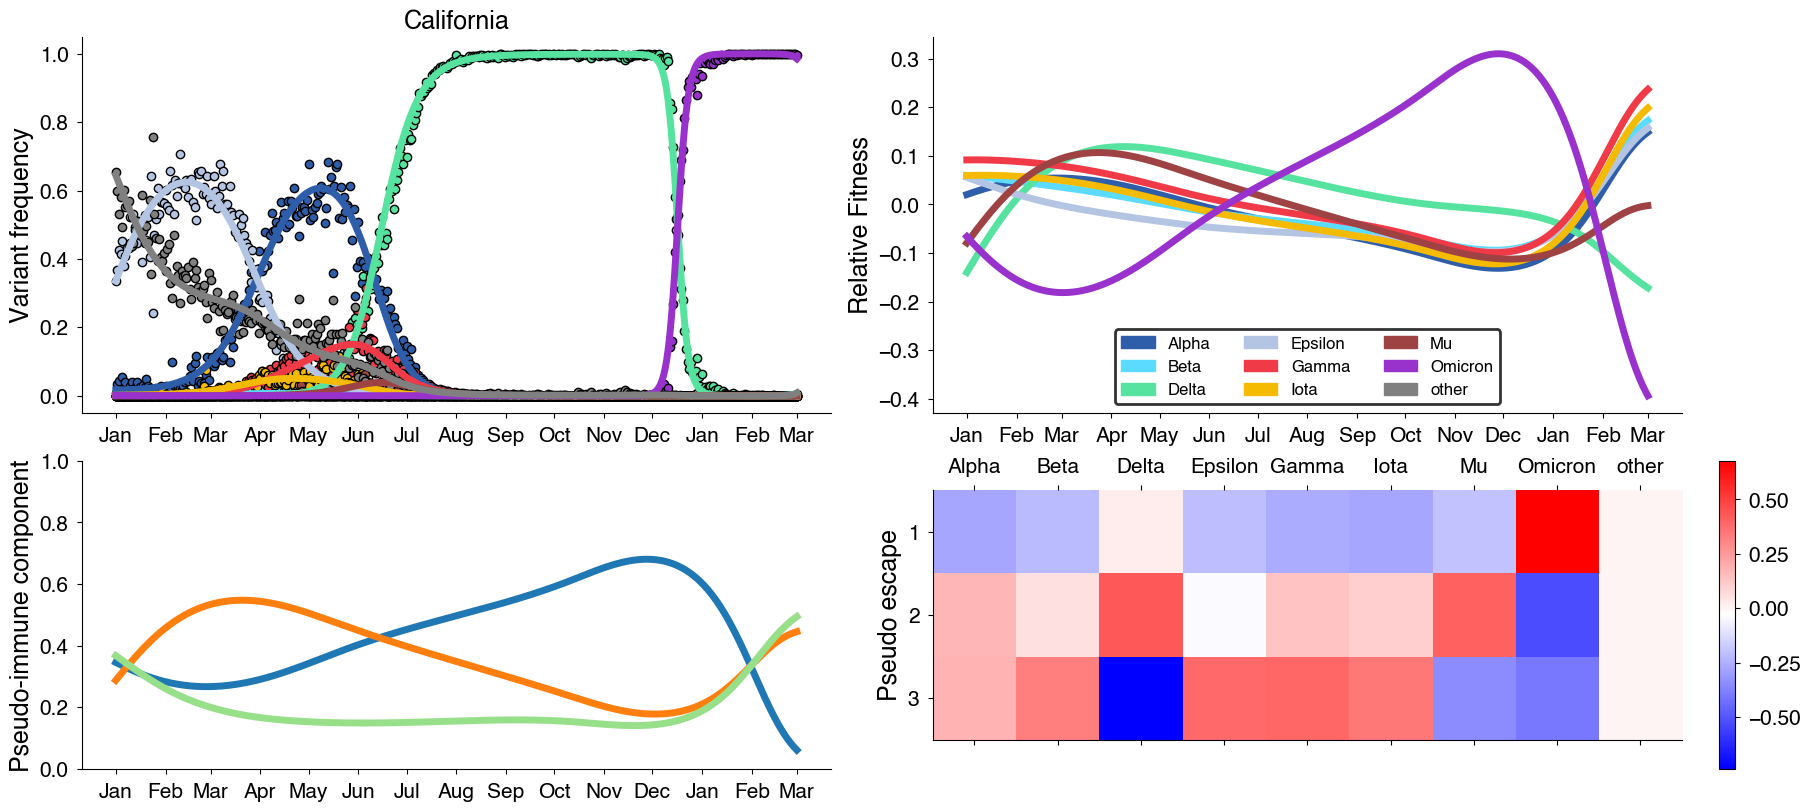

In [71]:
from evofr.plotting import * 

v_colors =["#2e5eaa", "#5adbff",  "#56e39f","#b4c5e4", "#f03a47",  "#f5bb00", "#9e4244","#9932CC", "#808080"] 
v_names = ['Alpha', 'Beta', 'Delta', 'Epsilon', 'Gamma', 'Iota', 'Mu', 'Omicron', 'other']
color_map = {v : c for c, v in zip(v_colors, v_names)}

def summary_plot_hier(posterior, group, location, color_map):
    if group is None:
        group = posterior.data.names.index(location)
    fig = plt.figure(figsize=(18., 8.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=2, nrows=2, height_ratios=[0.55, 0.45])
    
    _posterior = get_posterior(posterior, ["freq", "delta", "phi"], group)
    
    # Frequency
    ax = fig.add_subplot(spec[0])
    freq_plot = FrequencyPlot(_posterior, color_map=color_map).plot(ax=ax);
    add_dates(ax, posterior.data.dates)
    ax.set_title(posterior.data.names[group])
    
    # Relative Fitness
    ax = fig.add_subplot(spec[1])
    delta_plot = TimeVaryingPlot(posterior=_posterior, color_map=color_map, site="delta").plot(ax=ax)
    delta_plot.ax.set_ylabel("Relative Fitness")
    add_dates(ax, posterior.data.dates)
    
    ## Add color bar
    delta_plot.color_map
    PatchLegend(color_map=color_map, loc="lower center", ncol=3).add_legend(ax)
    
    # Phi 
    ax = fig.add_subplot(spec[2])
    #phi_cmap = plt.get_cmap('Set2', latent_dim)
    #phi_colormap = {v: phi_cmap(i / latent_dim) for i, v in enumerate(delta_plot.color_map.keys()) }
    
    phi_plot = TimeVaryingPlot(posterior=_posterior, site="phi").plot(ax=ax)
    phi_plot.ax.set_ylabel("Phi")
    ax.set_ylabel("Pseudo-immune component")
    add_dates(ax, posterior.data.dates)
    ax.set_ylim(0,1)

    # Eta
    eta = posterior.samples["eta"][0, :, :]
    n_vars, n_comps = eta.shape
    
    ax = fig.add_subplot(spec[3])
    cax = ax.matshow(eta.T, cmap="bwr")
    ax.set_xticks(np.arange(n_vars))
    ax.set_xticklabels(posterior.data.var_names)
    ax.set_yticks(np.arange(n_comps))
    ax.set_yticklabels(np.arange(1, n_comps + 1))
    ax.set_ylabel("Pseudo escape")
    fig.colorbar(cax)
    
    return None

summary_plot_hier(posterior, None, "California", color_map)

In [13]:
from sklearn.manifold import MDS
eta = posterior.samples["eta"][0,:,:]
eta_transformed = MDS(normalized_stress="auto").fit_transform(eta)

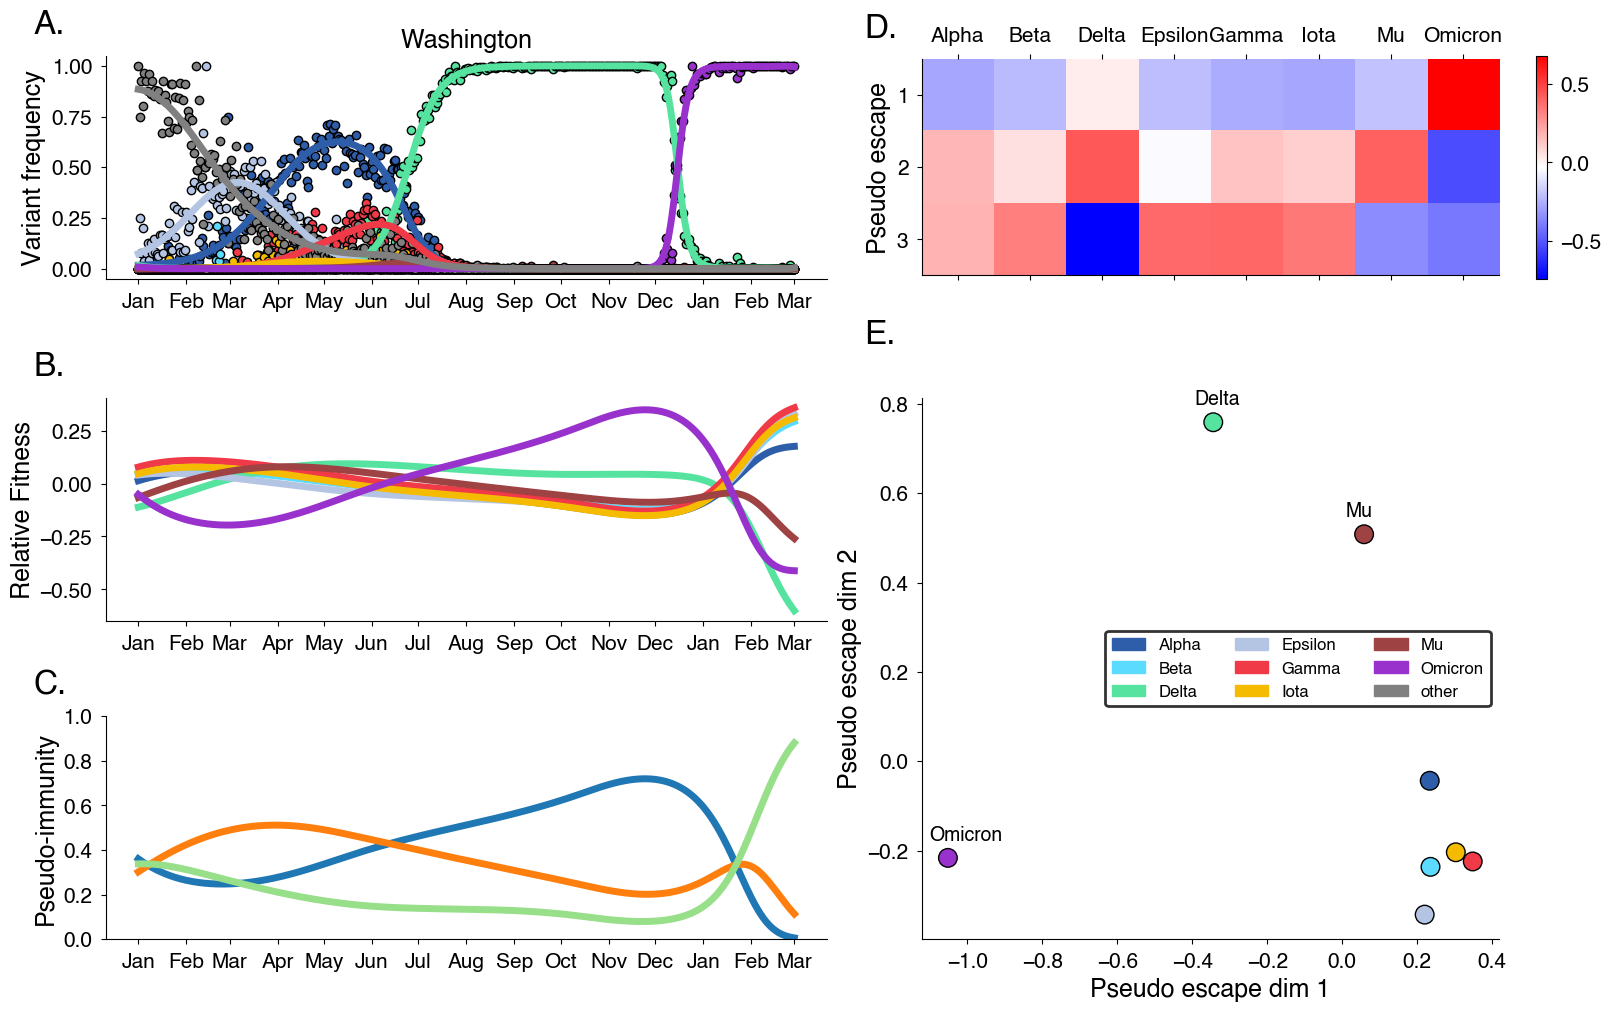

In [72]:
def summary_plot_hier(posterior, group, location, color_map):
    if group is None:
        group = posterior.data.names.index(location)
    fig = plt.figure(figsize=(16., 10.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=3, nrows=3, width_ratios=[0.5, 0.5, 0.8])
    
    _posterior = get_posterior(posterior, ["freq", "delta", "phi"], group)
    
    axes = []
    
    # Frequency
    ax = fig.add_subplot(spec[0, 0:2])
    freq_plot = FrequencyPlot(_posterior, color_map=color_map).plot(ax=ax);
    add_dates(ax, posterior.data.dates)
    ax.set_title(posterior.data.names[group])
    axes.append(ax)
    
    # Relative Fitness
    ax = fig.add_subplot(spec[1, 0:2])
    delta_plot = TimeVaryingPlot(posterior=_posterior, color_map=color_map, site="delta").plot(ax=ax)
    delta_plot.ax.set_ylabel("Relative Fitness")
    add_dates(ax, posterior.data.dates)
    axes.append(ax)
 
    
    # Phi 
    ax = fig.add_subplot(spec[2, 0:2])
    phi_plot = TimeVaryingPlot(posterior=_posterior, site="phi").plot(ax=ax)
    phi_plot.ax.set_ylabel("Phi")
    ax.set_ylabel("Pseudo-immunity")
    add_dates(ax, posterior.data.dates)
    ax.set_ylim(0,1)
    axes.append(ax)

    # Eta
    eta = posterior.samples["eta"][0, :-1, :] # Remove other
    n_vars, n_comps = eta.shape
    
    ax = fig.add_subplot(spec[0:1,2])
    cax = ax.matshow(eta.T, cmap="bwr")
    ax.set_xticks(np.arange(n_vars))
    ax.set_xticklabels(posterior.data.var_names[:-1])
    ax.set_yticks(np.arange(n_comps))
    ax.set_yticklabels(np.arange(1, n_comps + 1))
    ax.set_ylabel("Pseudo escape")
    fig.colorbar(cax)
    axes.append(ax)
    
    # Variant reduced space
    eta_transformed = MDS(normalized_stress="auto", random_state=12).fit_transform(eta)
    ax = fig.add_subplot(spec[1:3,2])
    ax.scatter(eta_transformed[:,0], eta_transformed[:,1], 
               ec="k", 
               color=[delta_plot.color_map[v] for v in posterior.data.var_names[:-1]],
               s=180)
    ax.set_xlabel("Pseudo escape dim 1")
    ax.set_ylabel("Pseudo escape dim 2")    
    
    # Add names to variants
    for i, txt in enumerate(posterior.data.var_names[:-1]):
        if txt in ["Delta", "Omicron", "Mu"]:
            ax.annotate(txt, (eta_transformed[i,0] - 0.05, eta_transformed[i,1] + 0.04), size=14, weight="bold")
    axes.append(ax)
    
    PatchLegend(color_map=delta_plot.color_map, loc="best", ncol=3).add_legend(ax)
    
    # Add labels
    ax_labels = ["A", "B", "C", "D", "E"] 

    for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=24, weight='bold')
    return fig

fig_wa = summary_plot_hier(posterior, None, "Washington", color_map)

In [73]:
fig_wa.savefig("../manuscript/figures/" + "latent_immune.png")

In [14]:
# How do I deal with nans here?

In [15]:
# How do I want this to be used?

# Basically, if you specify a kernel you can easily estimate the relative fitnesses and plot forecasts with uncertainty
# The difficulties are specifying this diag?
# I wonder if I'm better off reimplementing a lot of this myself. 